**Problem Statement**

StumbleUpon is a user-curated web content discovery engine that recommends relevant, high quality pages and media to its users, based on their interests. While some pages we recommend, such as news articles or seasonal recipes, are only relevant for a short period of time, others maintain a timeless quality and can be recommended to users long after they are discovered. In other words, pages can either be classified as "ephemeral" or "evergreen". The ratings we get from our community give us strong signals that a page may no longer be relevant - but what if we could make this distinction ahead of time? A high quality prediction of "ephemeral" or "evergreen" would greatly improve a recommendation system like ours.

Many people know evergreen content when they see it, but can an algorithm make the same determination without human intuition? Your mission is to build a classifier which will evaluate a large set of URLs and label them as either evergreen or ephemeral. Can you out-class(ify) StumbleUpon? As an added incentive to the prize, a strong performance in this competition may lead to a career-launching internship at one of the best places to work in San Francisco.

**Data**

There are two components to the data provided for this challenge:

The first component is two files: train.tsv and test.tsv. Each is a tab-delimited text file containing the fields outlined below for 10,566 urls total. Fields for which no data is available are indicated with a question mark.

train.tsv is the training set and contains 7,395 urls. Binary evergreen labels (either evergreen (1) or non-evergreen (0)) are provided for this set. test.tsv is the test/evaluation set and contains 3,171 urls.



**Approach**

Instead of going for traditional methods, my approach is to try out the effect of the new advances in NLP technology. So to tackle this problem, I use Transformer architecture (BERT) from Hugging face library and TensorFlow 2.0 . Combining this two allows me to build a powerful state of the art model for the classification task.

Further to improve the score, I attach a bidirectional LSTM (BiLSTM) before passing the embeddings to the Dense Neural Network model.

BiLSTM helps to significantly improves the score. With a few tweaks on hyper parameters, using learning rate scheduler, etc, one can achieve a score of over 0.89 and beat the current SOTA.



In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

import tensorflow as tf 

In [2]:
df_train=pd.read_csv('/kaggle/input/stumbleupon/train.tsv',sep='\t')

df_test=pd.read_csv('/kaggle/input/stumbleupon/test.tsv',sep='\t',usecols=['urlid','boilerplate'])

In [3]:
df_train.head()



,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [4]:
df_test.head()

,urlid,boilerplate
0,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc..."
1,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f..."
2,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st..."
3,7640,"{""title"":""Father s Tactics Used by Assad to Cr..."
4,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui..."


In [5]:

df_train.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

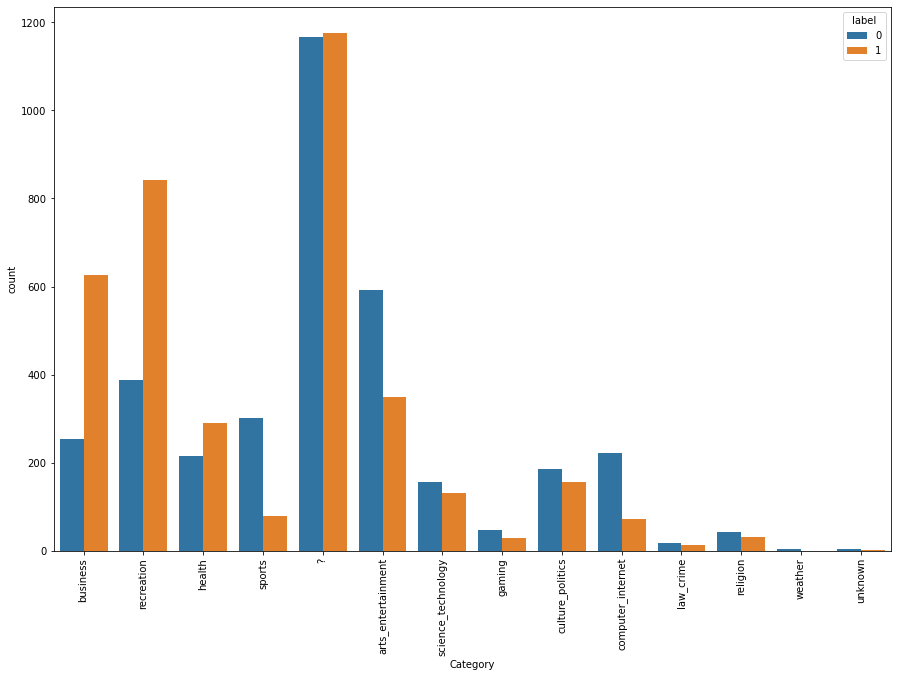

In [6]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

Alchemy catergory does have a role in determining the label for the article

We see that business, Recreation and health are more likley to be evergreen

Where as sports computer_internet and arts and entertainment are more like to be non-evergreen.

**Cleaning the boilerplate text**

Lets remove the title and url word from each description . We will also lower case the words as we are planing to used a uncased version of Transformer model

In [7]:
df_train['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_train['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_train['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_train['boilerplate']=df_train['boilerplate'].str.lower()


#Cleaning the test dataframe 

df_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_test['boilerplate']=df_test['boilerplate'].str.lower()


In [8]:
from transformers import AutoTokenizer, TFAutoModel


#Downloading the tokenizer and the Albert model for fine tuning

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert=TFAutoModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
#ADD all the variable for the Transformer model 
# because bert base uncased Model can only handle upto 512 tokens at a time
SEQ_length=512

#Lets create the X and Y matrix from the Df train set 

Xids=np.zeros((df_train.shape[0],SEQ_length))
Xmask=np.zeros((df_train.shape[0],SEQ_length))
y=np.zeros((df_train.shape[0],1))

#Preparing the test dataframe

Xids_test=np.zeros((df_test.shape[0],SEQ_length))
Xmask_test=np.zeros((df_test.shape[0],SEQ_length))
Xids




array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
for i,sequence in enumerate(df_train['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids[i,:],Xmask[i,:],y[i,0]=tokens['input_ids'],tokens['attention_mask'],df_train.loc[i,'label']
    

for i,sequence in enumerate(df_test['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids_test[i,:],Xmask_test[i,:]=tokens['input_ids'],tokens['attention_mask']

In [11]:
#Check if the GPU is avalaible
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
dataset=tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))

def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask},labels

dataset=dataset.map(map_func)
dataset=dataset.shuffle(100000).batch(64).prefetch(1000)

DS_size=len(list(dataset))


train=dataset.take(round(DS_size*0.90))
val=dataset.skip(round(DS_size*0.90))


In [13]:
#Preparing the test dataset

dataset_test=tf.data.Dataset.from_tensor_slices((Xids_test,Xmask_test))

def map_func(input_ids,mask):
    return {'input_ids':input_ids,'attention_mask':mask}

dataset_test=dataset_test.map(map_func)
dataset_test=dataset_test.batch(64).prefetch(1000)

In [14]:
from transformers import TFDistilBertModel, DistilBertConfig
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.4, attention_dropout=0.4)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

input_ids_in = tf.keras.layers.Input(shape=(SEQ_length,), name='input_ids', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(SEQ_length,), name='attention_mask', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
  layer.trainable = False


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512, 200)     695200      tf_distil_bert_model[0][0]   

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
])

In [17]:
history=model.fit(train,validation_data=val,epochs=10)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/10


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


104/104 [==============================] - ETA: 0s - loss: 0.5829 - auc: 0.7519 - precision: 0.7231 - recall: 0.6834

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


104/104 [==============================] - 490s 5s/step - loss: 0.5823 - auc: 0.7526 - precision: 0.7237 - recall: 0.6837 - val_loss: 0.4339 - val_auc: 0.8833 - val_precision: 0.8844 - val_recall: 0.7275
Epoch 2/10
104/104 [==============================] - 478s 5s/step - loss: 0.4835 - auc: 0.8467 - precision: 0.8352 - recall: 0.7430 - val_loss: 0.4662 - val_auc: 0.8587 - val_precision: 0.8028 - val_recall: 0.7646
Epoch 3/10
104/104 [==============================] - 477s 5s/step - loss: 0.4750 - auc: 0.8544 - precision: 0.8236 - recall: 0.7626 - val_loss: 0.4120 - val_auc: 0.8894 - val_precision: 0.8687 - val_recall: 0.7814
Epoch 4/10
104/104 [==============================] - 477s 5s/step - loss: 0.4626 - auc: 0.8627 - precision: 0.8448 - recall: 0.7810 - val_loss: 0.4066 - val_auc: 0.9036 - val_precision: 0.8200 - val_recall: 0.8870
Epoch 5/10
104/104 [==============================] - 469s 5s/step - loss: 0.4596 - auc: 0.8659 - precision: 0.8217 - recall: 0.7807 - val_loss: 0.4551

Prediction on test data

In [18]:
predictions=model.predict(dataset_test)
df_test['label']=predictions

df_test.to_csv('submission.csv',columns=['urlid','label'],index=False)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [19]:
input_x=tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))

def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask}

input_x=input_x.map(map_func)
input_x=input_x.shuffle(100000).batch(32).prefetch(1000)

y_true = y
y_true

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]])

Precision and recall for both class

In [20]:
y_pred=model.predict(dataset)
y_pred


y_pred = np.round(y_pred)
y_pred


from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


              precision    recall  f1-score   support

         0.0       0.49      0.50      0.50      3599
         1.0       0.52      0.51      0.52      3796

    accuracy                           0.51      7395
   macro avg       0.51      0.51      0.51      7395
weighted avg       0.51      0.51      0.51      7395



Feel free to comment down for any doubts. If you find this notebook helpful, do share and upvote!!
